In [1]:
import requests
import pandas as pd

# Define date ranges
# One shot learning
train_start_date = '2023-01-01'
train_end_date = '2024-01-01'
test_start_date = '2024-01-01'
test_end_date = '2024-04-01'

# Fetch data from the API for training and testing
url_train = f"https://api.energy-charts.info/price?bzn=DE-LU&start={train_start_date}&end={train_end_date}"
url_test = f"https://api.energy-charts.info/price?bzn=DE-LU&start={test_start_date}&end={test_end_date}"

response_train = requests.get(url_train)
response_test = requests.get(url_test)

data_train = response_train.json()
data_test = response_test.json()

# Convert to DataFrame
train_df = pd.DataFrame({
    'timestamp': pd.to_datetime(data_train['unix_seconds'], unit='s'),
    'price': data_train['price']
})
test_df = pd.DataFrame({
    'timestamp': pd.to_datetime(data_test['unix_seconds'], unit='s'),
    'price': data_test['price']
})

# Clean the data (remove rows with null prices)
train_df = train_df.dropna()
test_df = test_df.dropna()

# Save DataFrames to CSV
train_df.to_csv('train_data.csv', index=False)
test_df.to_csv('test_data.csv', index=False)


In [2]:
import pandas as pd
# Load data from CSV
train_df = pd.read_csv('train_data.csv')
test_df = pd.read_csv('test_data.csv')

# Convert timestamp to datetime format
train_df['timestamp'] = pd.to_datetime(train_df['timestamp'])
test_df['timestamp'] = pd.to_datetime(test_df['timestamp'])

# Rename columns for NeuralForecast
train_df = train_df.rename(columns={'timestamp': 'ds', 'price': 'y'})
test_df = test_df.rename(columns={'timestamp': 'ds', 'price': 'y'})

# Add unique_id column
train_df['unique_id'] = 'electricity_prices'
test_df['unique_id'] = 'electricity_prices'

# Check date ranges
print("First date in train_df:", train_df['ds'].min())
print("Last date in train_df:", train_df['ds'].max())
print("First date in test_df:", test_df['ds'].min())
print("Last date in test_df:", test_df['ds'].max())

First date in train_df: 2022-12-31 23:00:00
Last date in train_df: 2024-01-01 22:00:00
First date in test_df: 2023-12-31 23:00:00
Last date in test_df: 2024-04-01 21:00:00


In [ ]:
from neuralforecast import NeuralForecast
from neuralforecast.models import VanillaTransformer
from neuralforecast.losses.pytorch import MAE

horizon = 24
historical = 24 * 7

model_name = 'VanillaTransformer'

# Set up the model with horizon = 24 (for day-ahead hourly forecasts)
models = [
    VanillaTransformer(
        h=horizon,  # Forecast horizon: 24 hours
        input_size=historical,  # Sequence length (7 days of historical data)
        loss=MAE(),
    ),
]



# Train the model on the entire training data
nf = NeuralForecast(models=models, freq='h')
nf.fit(df=train_df)

In [ ]:

# Define the date range for generating predictions
daterange = pd.date_range(
    start=test_df["ds"].min(),
    end=test_df["ds"].max() - pd.Timedelta(hours=historical),
    freq="24H"
)

# Generate predictions for each 7-day window
predictions = [
    nf.predict(test_df[(test_df["ds"] >= d) & (test_df["ds"] < d + pd.Timedelta(hours=historical))])
    for d in daterange
]

# Combine predictions into a single DataFrame
forecast_df = pd.concat(predictions, ignore_index=True)

# Ensure predictions align with the test dataset
forecast_df = forecast_df[["ds", model_name]].merge(test_df[["ds", "y"]], on="ds", how="inner")
forecast_df.rename(columns={"y": "y_actual", model_name: "y_pred"}, inplace=True)

In [6]:
forecast_df.head()

,ds,y_pred,y_actual
0,2024-01-07 23:00:00,91.408318,87.02
1,2024-01-08 00:00:00,71.289925,84.32
2,2024-01-08 01:00:00,88.190170,81.82
3,2024-01-08 02:00:00,88.193726,79.11
4,2024-01-08 03:00:00,65.165695,78.48


In [7]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Calculate error metrics
mae = mean_absolute_error(forecast_df['y_actual'], forecast_df['y_pred'])
mse = mean_squared_error(forecast_df['y_actual'], forecast_df['y_pred'])
rmse = np.sqrt(mse)

# Print the results
print("Model Performance:")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")

Model Performance:
Mean Absolute Error (MAE): 36.83
Mean Squared Error (MSE): 1761.85
Root Mean Squared Error (RMSE): 41.97


In [8]:
# Merge forecasted values with actual test data, selecting only the relevant columns
comparison_df = forecast_df[['ds', 'y_pred']].merge(test_df[['ds', 'y']], on='ds', how='inner')
comparison_df.rename(columns={'y': 'y_actual', 'y_pred': 'y_pred'}, inplace=True)

# Add a column for the day of the week (0=Monday, 1=Tuesday, ..., 6=Sunday)
comparison_df['day_of_week'] = comparison_df['ds'].dt.dayofweek

# Calculate and display MAE, MSE, and RMSE for each day of the week
metrics_by_day = {}

for day in range(7):
    # Filter data for each day of the week
    day_data = comparison_df[comparison_df['day_of_week'] == day]

    # Calculate the metrics for this day
    mae = mean_absolute_error(day_data['y_actual'], day_data['y_pred'])
    mse = mean_squared_error(day_data['y_actual'], day_data['y_pred'])
    rmse = np.sqrt(mse)

    # Store the metrics for each day
    metrics_by_day[day] = {
        'MAE': mae,
        'MSE': mse,
        'RMSE': rmse
    }

    # Print the results for each day
    day_name = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'][day]
    print(f"MAE of {model_name} for {day_name} is: {mae:.2f}")
    print(f"MSE of {model_name} for {day_name} is: {mse:.2f}")
    print(f"RMSE of {model_name} for {day_name} is: {rmse:.2f}")
    print('-' * 50)

# Optionally, you can store these results in a DataFrame for easy viewing or further analysis
metrics_df = pd.DataFrame(metrics_by_day).T
print("\nMetrics by Day of the Week:")
print(metrics_df)

MAE of VanillaTransformer for Monday is: 35.01
MSE of VanillaTransformer for Monday is: 1685.36
RMSE of VanillaTransformer for Monday is: 41.05
--------------------------------------------------
MAE of VanillaTransformer for Tuesday is: 35.98
MSE of VanillaTransformer for Tuesday is: 1730.23
RMSE of VanillaTransformer for Tuesday is: 41.60
--------------------------------------------------
MAE of VanillaTransformer for Wednesday is: 31.97
MSE of VanillaTransformer for Wednesday is: 1305.15
RMSE of VanillaTransformer for Wednesday is: 36.13
--------------------------------------------------
MAE of VanillaTransformer for Thursday is: 33.33
MSE of VanillaTransformer for Thursday is: 1437.07
RMSE of VanillaTransformer for Thursday is: 37.91
--------------------------------------------------
MAE of VanillaTransformer for Friday is: 35.04
MSE of VanillaTransformer for Friday is: 1553.98
RMSE of VanillaTransformer for Friday is: 39.42
--------------------------------------------------
MAE of 

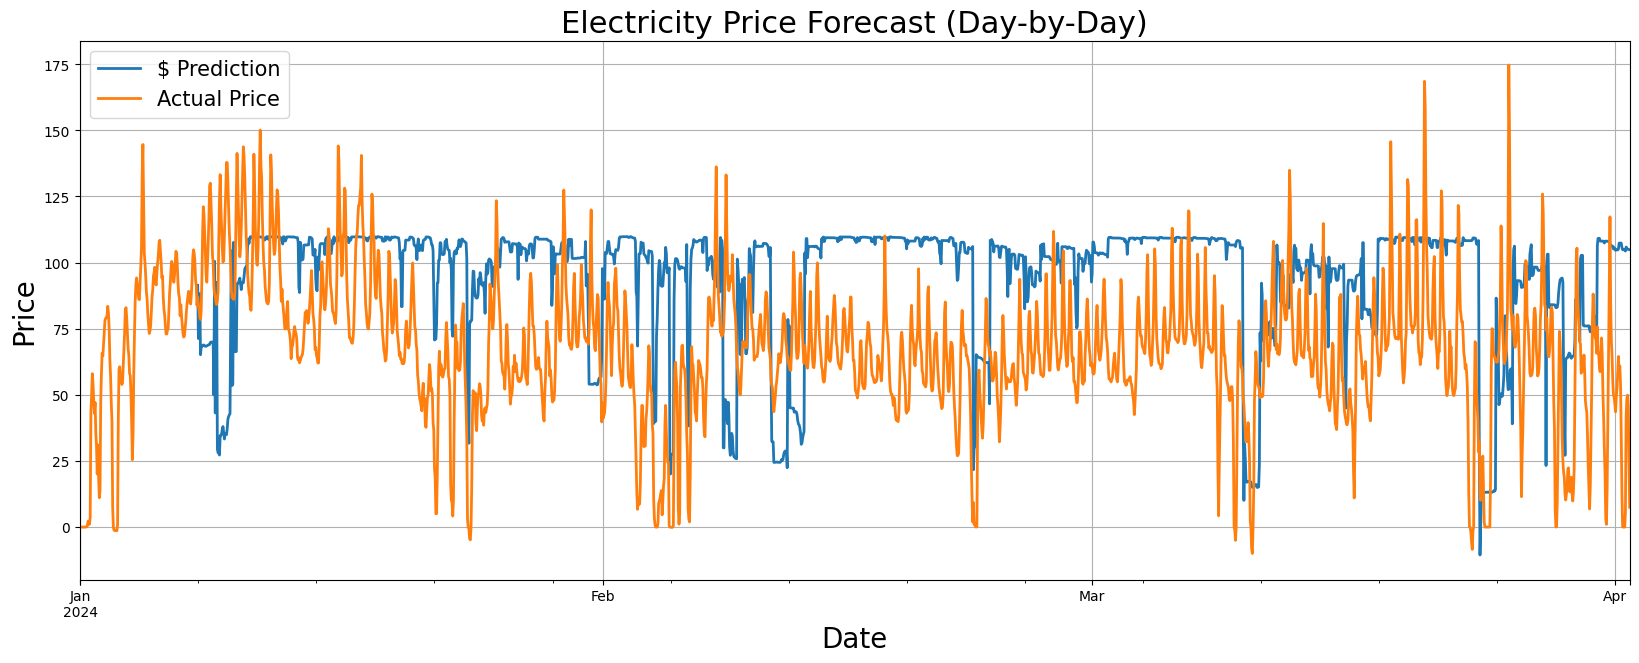

In [9]:
import matplotlib.pyplot as plt

# Plotting
fig, ax = plt.subplots(1, 1, figsize=(20, 7))

# Plot predictions for model
forecast_df.set_index('ds')['y_pred'].plot(ax=ax, linewidth=2, label= f'$ Prediction')

# Optional: Plot actual test values for comparison
test_df.set_index('ds')['y'].plot(ax=ax, linewidth=2, label='Actual Price')

# Formatting the plot
ax.set_title('Electricity Price Forecast (Day-by-Day)', fontsize=22)
ax.set_ylabel('Price', fontsize=20)
ax.set_xlabel('Date', fontsize=20)
ax.legend(prop={'size': 15})
ax.grid()
plt.show()

In [10]:
overall_mean = test_df['y'].mean()

# Print the overall mean
print(f"Overall Mean Price: {overall_mean}")

Overall Mean Price: 67.32826008155868


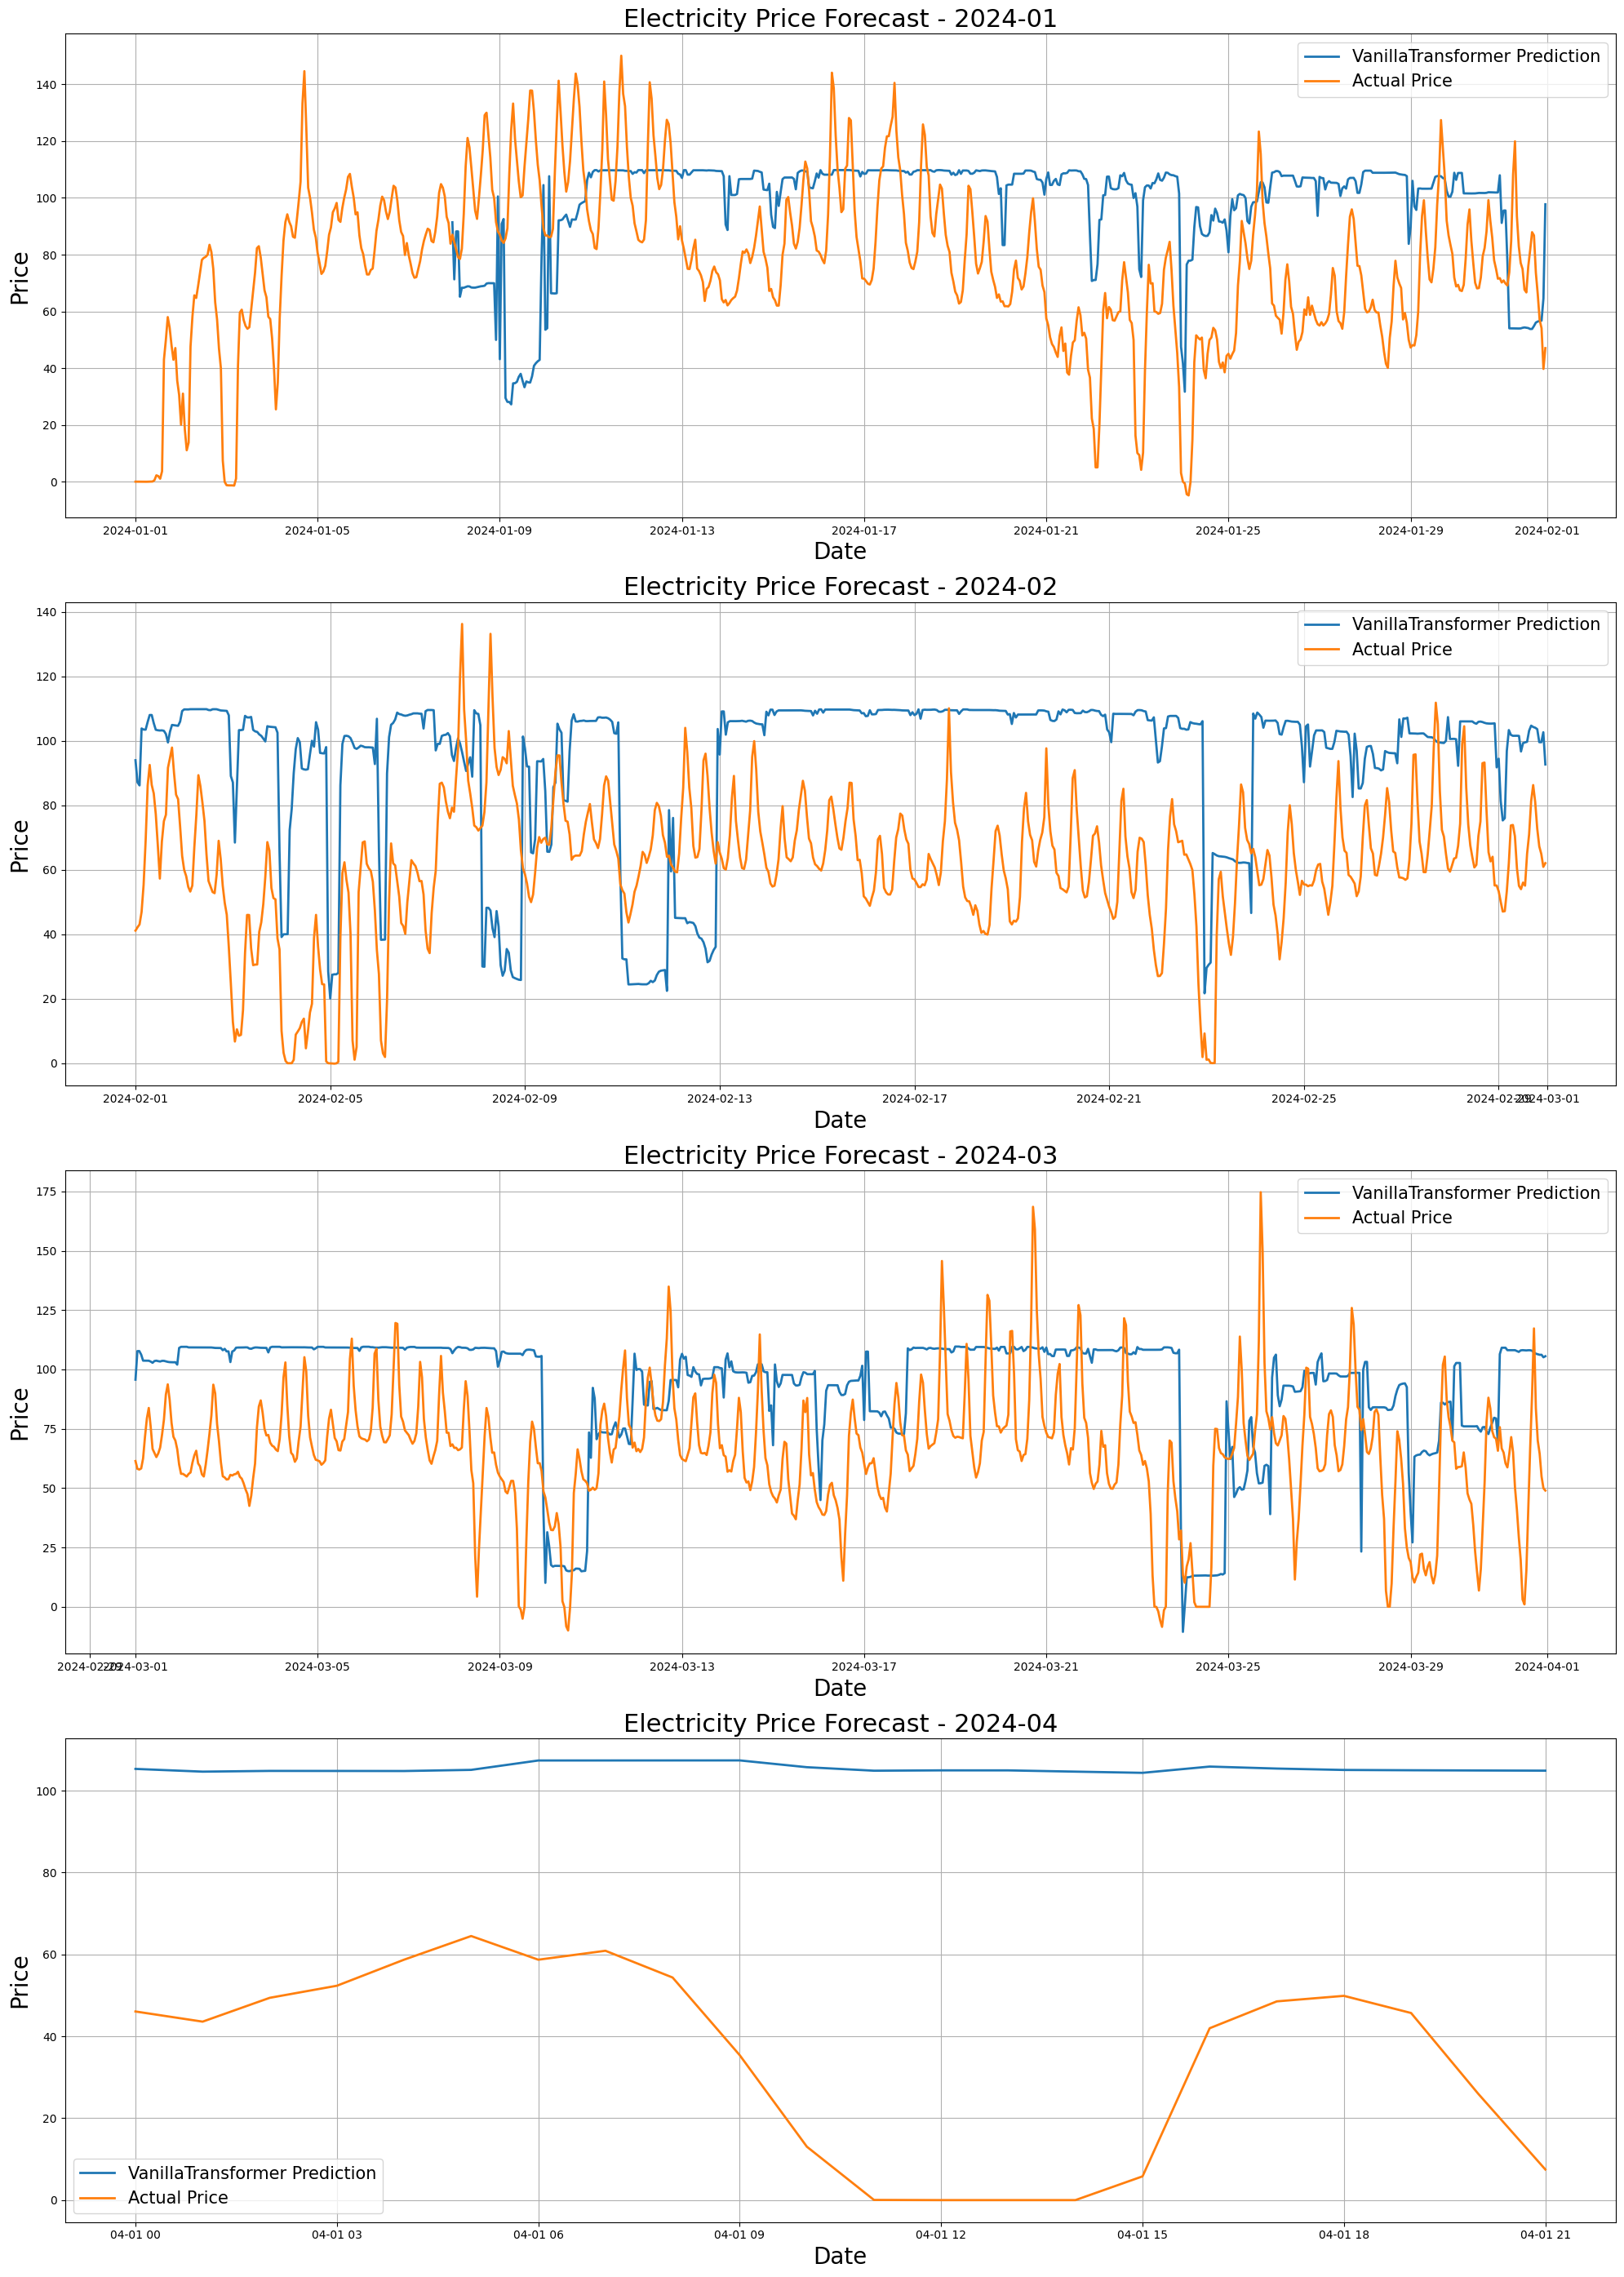

In [11]:
import matplotlib.pyplot as plt
import pandas as pd

# Ensure 'ds' is in datetime format
forecast_df['ds'] = pd.to_datetime(forecast_df['ds'])
test_df['ds'] = pd.to_datetime(test_df['ds'])

# Create a new figure with multiple subplots, one for each month
unique_months = forecast_df['ds'].dt.to_period('M').unique()

# Set up the figure and axes for plotting
fig, axes = plt.subplots(len(unique_months), 1, figsize=(20, 7 * len(unique_months)))

if len(unique_months) == 1:
    axes = [axes]  # Ensure axes is iterable even if there's only one subplot

for i, month in enumerate(unique_months):
    # Create the data subset for the current month
    month_str = str(month)
    forecast_month = forecast_df[forecast_df['ds'].dt.to_period('M') == month]
    test_month = test_df[test_df['ds'].dt.to_period('M') == month]

    # Plot predictions for the current month
    axes[i].plot(forecast_month['ds'], forecast_month['y_pred'], linewidth=2, label=f'{model_name} Prediction')

    # Plot actual test values for comparison in the current month
    axes[i].plot(test_month['ds'], test_month['y'], linewidth=2, label='Actual Price')

    # Formatting the plot for the current month
    axes[i].set_title(f'Electricity Price Forecast - {month_str}', fontsize=22)
    axes[i].set_ylabel('Price', fontsize=20)
    axes[i].set_xlabel('Date', fontsize=20)
    axes[i].legend(prop={'size': 15})
    axes[i].grid()

# Show the plot
plt.tight_layout()
plt.show()

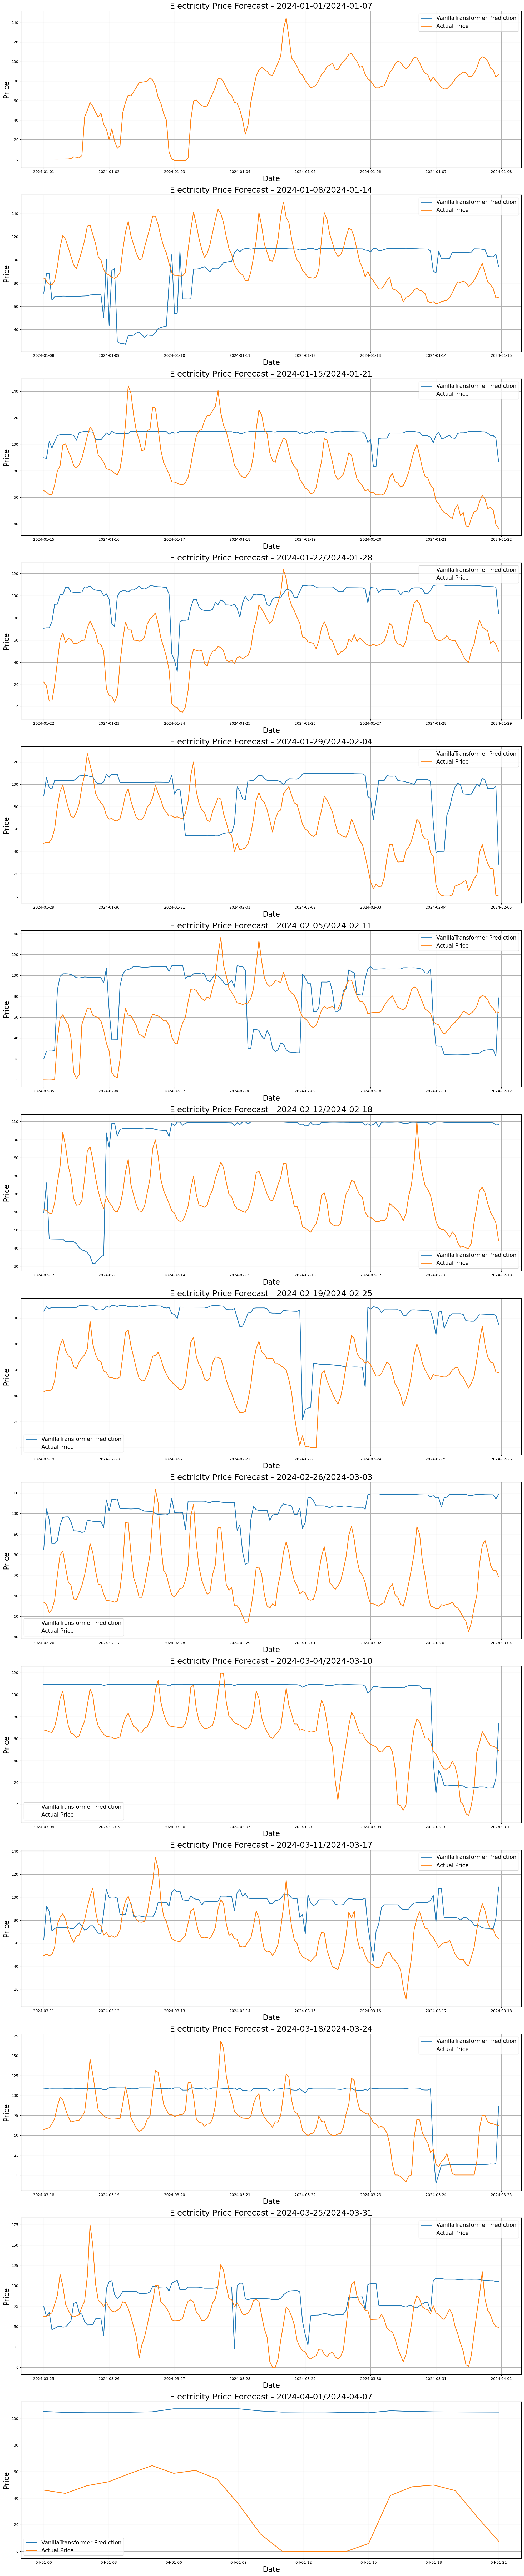

In [12]:
import matplotlib.pyplot as plt
import pandas as pd

# Ensure 'ds' is in datetime format
forecast_df['ds'] = pd.to_datetime(forecast_df['ds'])
test_df['ds'] = pd.to_datetime(test_df['ds'])

# Create a new figure with multiple subplots, one for each biweekly period
# Group the data by biweekly periods
forecast_df['biweek'] = forecast_df['ds'].dt.to_period('2W')
test_df['biweek'] = test_df['ds'].dt.to_period('2W')

# Get the unique biweekly periods
unique_biweeks = forecast_df['biweek'].unique()

# Set up the figure and axes for plotting
fig, axes = plt.subplots(len(unique_biweeks), 1, figsize=(20, 7 * len(unique_biweeks)))

if len(unique_biweeks) == 1:
    axes = [axes]  # Ensure axes is iterable even if there's only one subplot

for i, biweek in enumerate(unique_biweeks):
    # Create the data subset for the current biweekly period
    biweek_str = str(biweek)
    forecast_biweek = forecast_df[forecast_df['biweek'] == biweek]
    test_biweek = test_df[test_df['biweek'] == biweek]

    # Plot predictions for the current biweekly period
    axes[i].plot(forecast_biweek['ds'], forecast_biweek['y_pred'], linewidth=2, label=f'{model_name} Prediction')

    # Plot actual test values for comparison in the current biweekly period
    axes[i].plot(test_biweek['ds'], test_biweek['y'], linewidth=2, label='Actual Price')

    # Formatting the plot for the current biweekly period
    axes[i].set_title(f'Electricity Price Forecast - {biweek_str}', fontsize=22)
    axes[i].set_ylabel('Price', fontsize=20)
    axes[i].set_xlabel('Date', fontsize=20)
    axes[i].legend(prop={'size': 15})
    axes[i].grid()

# Show the plot
plt.tight_layout()
plt.show()